In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#import scienceplots
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import tensorflow.keras.callbacks
from keras import backend as K
from keras.regularizers import l2
import albumentations as A

In [2]:
train_transforms = A.Compose([
    A.VerticalFlip(),
    A.HorizontalFlip(),
    A.Rotate(limit=30),
    A.GaussNoise(var_limit=0.01)
])

val_transforms = A.Compose([
    A.NoOp()
])

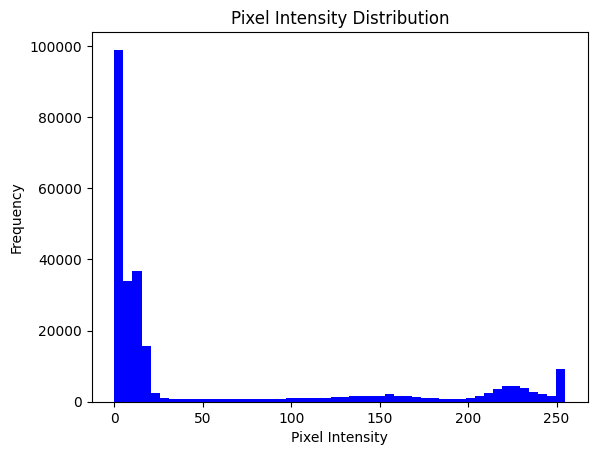

In [3]:
image = cv2.imread(r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan\volume-0_slice_56.jpg", cv2.IMREAD_GRAYSCALE)

hist = cv2.calcHist([image], [0], None, [256], [0, 256])

plt.hist(image.flatten(), bins=50, color='blue')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

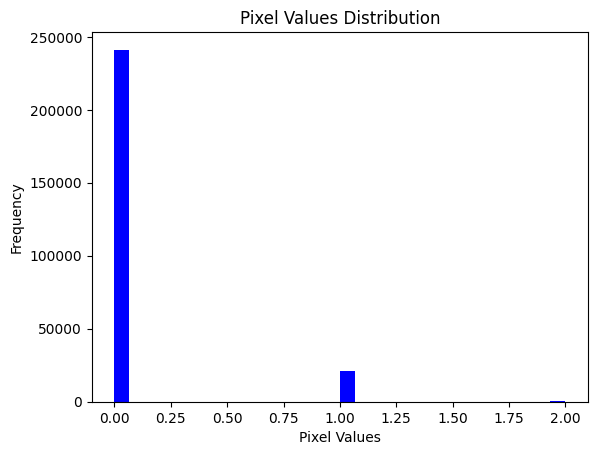

In [4]:
mask = cv2.imread(r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan_masks\volume-0_slice_56.tiff", cv2.IMREAD_GRAYSCALE)


plt.hist(mask.flatten(), bins=30, color='blue')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Pixel Values Distribution')
plt.show()

In [5]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(9, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.title(' '.join(name.split('_')).title())

        if 'mask' in name:
            if image.ndim == 3 and image.shape[-1] > 1:
                image = np.argmax(image, axis=-1)
                
        plt.imshow(image, cmap = 'bone')
    plt.show()

In [6]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    x = np.repeat(x, 3, axis=-1)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.int32)
    return x

In [7]:
def load_data(x_path, y_path):
    images = os.listdir(x_path)
    masks = os.listdir(y_path)
    
    X = [os.path.join(x_path, image) for image in images]
    y = [os.path.join(y_path, mask) for mask in masks]
    
    train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
    train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42)

    return train_x, train_y, val_x, val_y, test_x, test_y

In [8]:
def tf_dataset(x, y, transformations, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=len(x))
    dataset = dataset.map(lambda x, y: preprocess(x, y, transformations))
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

def preprocess(x, y, transformations):

    def aug(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        augmented = transformations(image=image,mask=mask)
        aug_img=augmented['image']
        aug_mask = augmented['mask']
        return aug_img, aug_mask
    
    image, mask = tf.numpy_function(aug, [x,y], [tf.float32, tf.int32])

    mask = tf.one_hot(mask, 3, dtype = tf.int32) #обязательно так как сегментация мультиклассовая

    image.set_shape([512,512,3])
    mask.set_shape([512,512,3])

    return image, mask

In [9]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, concatenate, Conv2DTranspose, Activation, BatchNormalization, Dropout, Lambda

def UNet(n_classes=3, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=3):
  
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    #contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    #bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #expansion path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs], name='UNET')
    
    return model

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_3Class(y_true, y_pred, numLabels=3):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels

In [11]:
Ncl = 3
w = K.zeros(shape=(Ncl,))

def generalized_dice_coeff(y_true, y_pred):
    y_pred = K.cast(y_pred, 'float32')
    y_true = K.cast(y_true, 'float32')
    # print(y_pred.dtype, y_true.dtype)
    # Ncl = y_pred.shape[-1]
    # w = K.zeros(shape=(Ncl,))
    w = K.sum(y_true, axis=(0,1,2))
    w = 1.0/(w**2+0.000001)

    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2))
    numerator = K.sum(numerator)

    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2))
    denominator = K.sum(denominator)

    gen_dice_coef = 2*numerator/denominator

    return gen_dice_coef

def generalized_dice_loss(y_true, y_pred):
    return 1 - generalized_dice_coeff(y_true, y_pred)

In [12]:
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

## Гиперпараметры модели

In [13]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
n_classes = 3

LR = 1e-4
epochs = 50

## Модель

In [14]:
# model_unet = UNet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
# model_unet.compile(loss=generalized_dice_loss, optimizer=tf.keras.optimizers.Adam(LR), metrics = [dice_coef_3Class, tf.keras.metrics.OneHotMeanIoU(num_classes=3)])
# model_unet.summary()

## Формирование датасета и Визуализация

In [15]:
np.random.seed(42)
tf.random.set_seed(42)
# i = random.randint(0, 4308)
batch_size = 4

images_path = r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan"
masks_path = r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan_masks"

train_x, train_y, val_x, val_y, test_x, test_y = load_data(images_path, masks_path)

train_ds = tf_dataset(train_x, train_y, transformations=train_transforms, batch=batch_size)
val_ds = tf_dataset(val_x, val_y, transformations=val_transforms, batch=batch_size)

In [16]:
len(train_x) / (len(train_x) + len(val_x) + len(test_x))

0.5998886259223166

(4, 512, 512, 3)
0


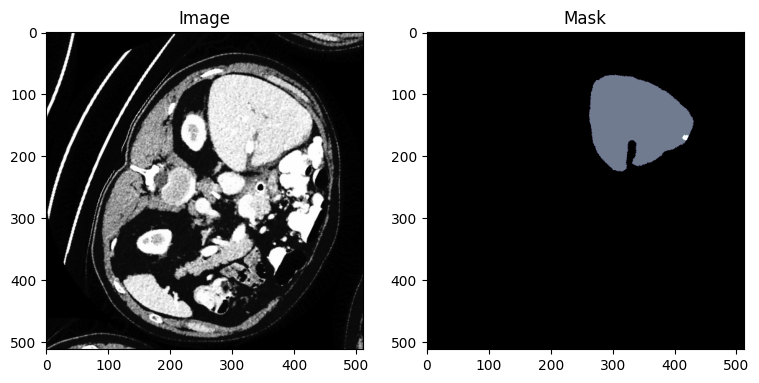

1


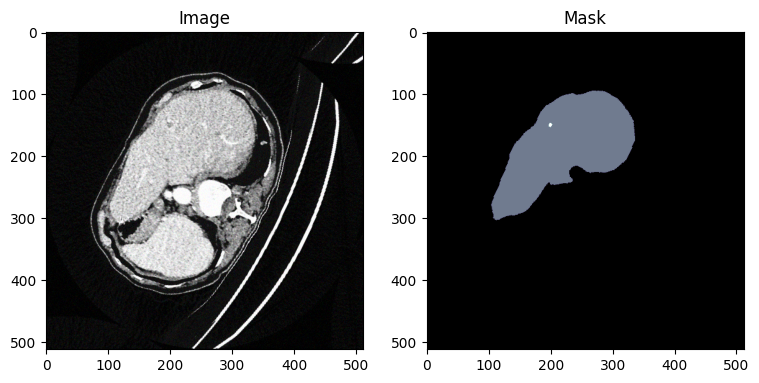

2


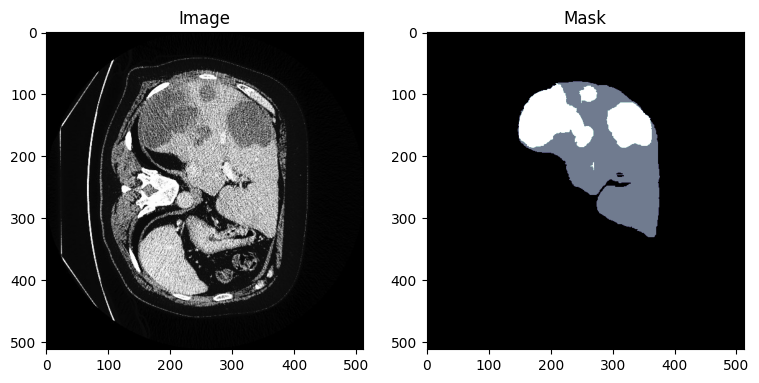

3


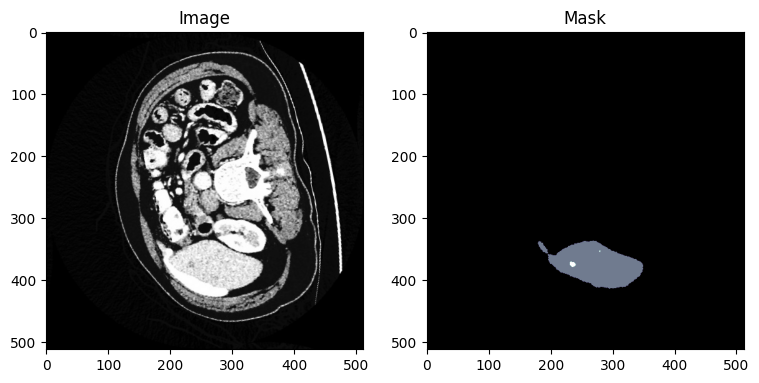

In [17]:
for images, labels in train_ds.take(1): 
    numpy_images = images.numpy()
    numpy_masks = labels.numpy()
    print(numpy_masks.shape)
    for i in range(numpy_images.shape[0]):
        print(i)
        visualize(image = numpy_images[i, ...], mask = numpy_masks[i, ...])

In [18]:
train_steps = len(train_x)//batch_size
valid_steps = len(val_x)//batch_size

history_class = LossHistory()

callbacks = [
    ModelCheckpoint("UNet.hdf5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.1, verbose=1, min_lr=1e-6),
    # EarlyStopping(monitor="val_loss", patience=2, verbose=1,min_delta=0.001),
    TensorBoard(log_dir='logs'),
    history_class
]


In [25]:
unet_history = model_unet.fit(train_ds,
                    steps_per_epoch=train_steps,validation_data=val_ds,
                    validation_steps=valid_steps,epochs=epochs,
                    callbacks=callbacks,verbose = 1)

model_unet.save('final_UNet.hdf5')

Epoch 1/50
538/538 [==============================] - ETA: 0s - loss: 0.7820 - dice_coef_3Class: 0.4301 - one_hot_mean_io_u: 0.2996
Epoch 1: saving model to UNet.hdf5
538/538 [==============================] - 159s 276ms/step - loss: 0.7820 - dice_coef_3Class: 0.4301 - one_hot_mean_io_u: 0.2996 - val_loss: 0.6440 - val_dice_coef_3Class: 0.6257 - val_one_hot_mean_io_u: 0.5167 - lr: 1.0000e-04
Epoch 2/50
538/538 [==============================] - ETA: 0s - loss: 0.4817 - dice_coef_3Class: 0.7260 - one_hot_mean_io_u: 0.6194
Epoch 2: saving model to UNet.hdf5
538/538 [==============================] - 141s 257ms/step - loss: 0.4817 - dice_coef_3Class: 0.7260 - one_hot_mean_io_u: 0.6194 - val_loss: 0.5697 - val_dice_coef_3Class: 0.6674 - val_one_hot_mean_io_u: 0.5558 - lr: 1.0000e-04
Epoch 3/50
538/538 [==============================] - ETA: 0s - loss: 0.4149 - dice_coef_3Class: 0.7701 - one_hot_mean_io_u: 0.6719
Epoch 3: saving model to UNet.hdf5
538/538 [==============================] - 

## Реализация модели resunet plus plus unet

In [17]:
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def SE(inputs, ratio=8):
    channel_axis = -1
    num_filters = inputs.shape[channel_axis]
    se_shape = (1, 1, num_filters)

    x = L.GlobalAveragePooling2D()(inputs)
    x = L.Reshape(se_shape)(x)
    x = L.Dense(num_filters // ratio, activation='relu', use_bias=False)(x)
    x = L.Dense(num_filters, activation='sigmoid', use_bias=False)(x)

    x = L.Multiply()([inputs, x])
    return x


def stem_block(inputs, num_filters):
    ## Conv 1
    x = L.Conv2D(num_filters, 3, padding="same")(inputs)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)

    ## Shortcut
    s = L.Conv2D(num_filters, 1, padding="same")(inputs)

    ## Add
    x = L.Add()([x, s])
    return x

def resnet_block(inputs, num_filters, strides=1):
    ## SE
    inputs = SE(inputs)

    ## Conv 1
    x = L.BatchNormalization()(inputs)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same", strides=strides)(x)

    ## Conv 2
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same", strides=1)(x)

    ## Shortcut
    s = L.Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    ## Add
    x = L.Add()([x, s])

    return x

def aspp_block(inputs, num_filters):
    x1 = L.Conv2D(num_filters, 3, dilation_rate=6, padding="same")(inputs)
    x1 = L.BatchNormalization()(x1)

    x2 = L.Conv2D(num_filters, 3, dilation_rate=12, padding="same")(inputs)
    x2 = L.BatchNormalization()(x2)

    x3 = L.Conv2D(num_filters, 3, dilation_rate=18, padding="same")(inputs)
    x3 = L.BatchNormalization()(x3)

    x4 = L.Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x4 = L.BatchNormalization()(x4)

    y = L.Add()([x1, x2, x3, x4])
    y = L.Conv2D(num_filters, 1, padding="same")(y)

    return y

def attetion_block(x1, x2):
    num_filters = x2.shape[-1]

    x1_conv = L.BatchNormalization()(x1)
    x1_conv = L.Activation("relu")(x1_conv)
    x1_conv = L.Conv2D(num_filters, 3, padding="same")(x1_conv)
    x1_pool = L.MaxPooling2D((2, 2))(x1_conv)

    x2_conv = L.BatchNormalization()(x2)
    x2_conv = L.Activation("relu")(x2_conv)
    x2_conv = L.Conv2D(num_filters, 3, padding="same")(x2_conv)

    x = L.Add()([x1_pool, x2_conv])

    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)

    x = L.Multiply()([x, x2])
    return x

def resunet_pp(n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS):
    """ Inputs """
    inputs = L.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    """ Encoder """
    c1 = stem_block(inputs, 16)
    c2 = resnet_block(c1, 32, strides=2)
    c3 = resnet_block(c2, 64, strides=2)
    c4 = resnet_block(c3, 128, strides=2)

    """ Bridge """
    b1 = aspp_block(c4, 256)

    """ Decoder """
    d1 = attetion_block(c3, b1)
    d1 = L.UpSampling2D((2, 2))(d1)
    d1 = L.Concatenate()([d1, c3])
    d1 = resnet_block(d1, 128)

    d2 = attetion_block(c2, d1)
    d2 = L.UpSampling2D((2, 2))(d2)
    d2 = L.Concatenate()([d2, c2])
    d2 = resnet_block(d2, 64)

    d3 = attetion_block(c1, d2)
    d3 = L.UpSampling2D((2, 2))(d3)
    d3 = L.Concatenate()([d3, c1])
    d3 = resnet_block(d3, 32)

    """ Output"""
    outputs = aspp_block(d3, 16)
    outputs = L.Conv2D(n_classes, 1, padding="same")(outputs)
    outputs = L.Activation("softmax")(outputs)

    """ Model """
    model = Model(inputs, outputs, name='RESUNET_pp')
    return model

In [18]:
model = resunet_pp(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(LR), metrics = [dice_coef_3Class, tf.keras.metrics.OneHotMeanIoU(num_classes=3)])
model.summary()

Model: "RESUNET_pp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d_19[0][0]']              
 alization)                     )                                                        

In [21]:
callbacks = [
    ModelCheckpoint("resunet_pp.hdf5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    # EarlyStopping(monitor="val_loss", patience=3, verbose=1,min_delta=0.0001),
    TensorBoard(log_dir='logs'),
    history_class
]

resunet_pp_history = model.fit(train_ds,
                    steps_per_epoch=train_steps,validation_data=val_ds,
                    validation_steps=valid_steps,epochs=epochs,
                    callbacks=callbacks,verbose = 1)

model.save('final_resunet_pp.hdf5')

Epoch 1/50


1077/1077 [==============================] - ETA: 0s - loss: 0.2138 - dice_coef_3Class: 0.5609 - one_hot_mean_io_u_1: 0.5514
Epoch 1: saving model to resunet_pp.hdf5
1077/1077 [==============================] - 642s 582ms/step - loss: 0.2138 - dice_coef_3Class: 0.5609 - one_hot_mean_io_u_1: 0.5514 - val_loss: 0.0956 - val_dice_coef_3Class: 0.6024 - val_one_hot_mean_io_u_1: 0.5749 - lr: 1.0000e-04
Epoch 2/50
1077/1077 [==============================] - ETA: 0s - loss: 0.0878 - dice_coef_3Class: 0.6629 - one_hot_mean_io_u_1: 0.6579
Epoch 2: saving model to resunet_pp.hdf5
1077/1077 [==============================] - 631s 583ms/step - loss: 0.0878 - dice_coef_3Class: 0.6629 - one_hot_mean_io_u_1: 0.6579 - val_loss: 0.1687 - val_dice_coef_3Class: 0.6008 - val_one_hot_mean_io_u_1: 0.5828 - lr: 1.0000e-04
Epoch 3/50
1077/1077 [==============================] - ETA: 0s - loss: 0.0596 - dice_coef_3Class: 0.7256 - one_hot_mean_io_u_1: 0.7250
Epoch 3: saving model to resunet_pp.hdf5
1077/1077 [=

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/RESUNET_pp/conv2d_57/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "c:\Users\stepan\anaconda3\envs\py310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\stepan\anaconda3\envs\py310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\stepan\anaconda3\envs\py310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\stepan\anaconda3\envs\py310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\stepan\anaconda3\envs\py310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Temp\ipykernel_6424\4133993023.py", line 9, in <module>
      resunet_pp_history = model.fit(train_ds,
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "c:\Users\stepan\anaconda3\envs\py310\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/RESUNET_pp/conv2d_57/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[4,32,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/RESUNET_pp/conv2d_57/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_12257]

VGG16 unet

In [19]:
from tensorflow.keras.applications import VGG16

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def vgg16_unet(n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS):
    """ Input """
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))


    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="VGG16_UNet")
    return model

In [20]:
vgg16unet_model = vgg16_unet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
vgg16unet_model.compile(loss=generalized_dice_loss, optimizer=tf.keras.optimizers.Adam(LR), metrics = [tf.keras.metrics.OneHotMeanIoU(num_classes=3)])
vgg16unet_model.summary()

Model: "VGG16_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                        

In [21]:
callbacks = [
    ModelCheckpoint("vgg16unet_model.hdf5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1,min_delta=0.0001),
    TensorBoard(log_dir='logs'),
    history_class
]

vgg16unet_model_history = vgg16unet_model.fit(train_ds,
                    steps_per_epoch=train_steps,validation_data=val_ds,
                    validation_steps=valid_steps,epochs=epochs,
                    callbacks=callbacks,verbose = 1)



Epoch 1/50
1077/1077 [==============================] - ETA: 0s - loss: 0.5646 - one_hot_mean_io_u: 0.3920
Epoch 1: saving model to vgg16unet_model.hdf5
1077/1077 [==============================] - 762s 692ms/step - loss: 0.5646 - one_hot_mean_io_u: 0.3920 - val_loss: 0.4126 - val_one_hot_mean_io_u: 0.6454 - lr: 1.0000e-04
Epoch 2/50
1077/1077 [==============================] - ETA: 0s - loss: 0.3728 - one_hot_mean_io_u: 0.7073
Epoch 2: saving model to vgg16unet_model.hdf5
1077/1077 [==============================] - 748s 691ms/step - loss: 0.3728 - one_hot_mean_io_u: 0.7073 - val_loss: 0.4258 - val_one_hot_mean_io_u: 0.6973 - lr: 1.0000e-04
Epoch 3/50
1077/1077 [==============================] - ETA: 0s - loss: 0.3402 - one_hot_mean_io_u: 0.7411
Epoch 3: saving model to vgg16unet_model.hdf5
1077/1077 [==============================] - 744s 691ms/step - loss: 0.3402 - one_hot_mean_io_u: 0.7411 - val_loss: 0.3141 - val_one_hot_mean_io_u: 0.7583 - lr: 1.0000e-04
Epoch 4/50
1077/1077 [===

NameError: name 'model' is not defined

In [22]:
vgg16unet_model.save('final_vgg16unet_model.hdf5')

## Визуализация результатов обучения

In [ ]:
unet_hist_df = pd.DataFrame(unet_history.history)

,loss,dice_coef_3Class,one_hot_mean_io_u,val_loss,val_dice_coef_3Class,val_one_hot_mean_io_u,lr
0,0.919721,0.096235,0.068175,0.887887,0.079682,0.043813,0.000100
1,0.793544,0.543130,0.443812,0.561613,0.688324,0.586869,0.000100
2,0.417289,0.775382,0.679959,0.421562,0.761938,0.664509,0.000100
3,0.362123,0.803674,0.712401,0.394975,0.780592,0.683409,0.000100
4,0.348566,0.809565,0.719801,0.366562,0.791897,0.696443,0.000100
5,0.320470,0.822383,0.732107,0.318283,0.822493,0.732941,0.000100
6,0.313024,0.826726,0.739554,0.310389,0.829846,0.743832,0.000100
7,0.301562,0.831830,0.745306,0.285983,0.840129,0.758390,0.000100
8,0.287797,0.838800,0.753489,0.296064,0.838893,0.752304,0.000100
9,0.276411,0.844417,0.760744,0.276655,0.843208,0.755134,0.000100


In [ ]:
hist_csv_file = 'history_unet.csv'
with open(hist_csv_file, mode='w') as f:
    unet_hist_df.to_csv(f)

In [23]:
vgg16unet_hist_df = pd.DataFrame(vgg16unet_model_history.history)

In [24]:
hist_csv_file = 'history_vgg16unet.csv'
with open(hist_csv_file, mode='w') as f:
    vgg16unet_hist_df.to_csv(f)

In [41]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

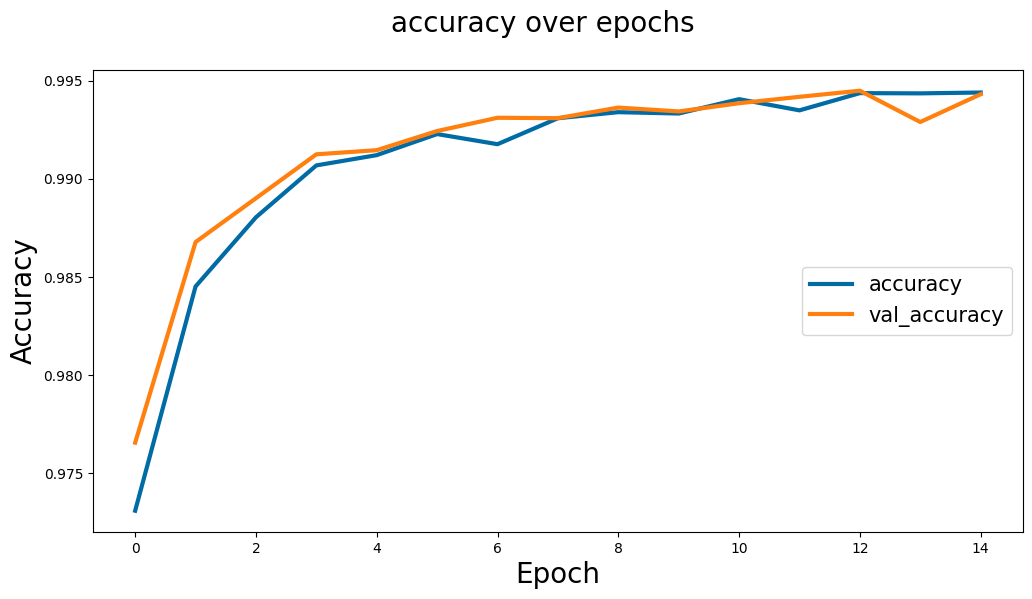

In [54]:
def plot_accuracy_history(history, metrics=["accuracy", "val_accuracy"]):
    plt.style.use(['tableau-colorblind10'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("accuracy over epochs", fontsize=20)
    plt.ylabel("Accuracy", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_accuracy_history(history)

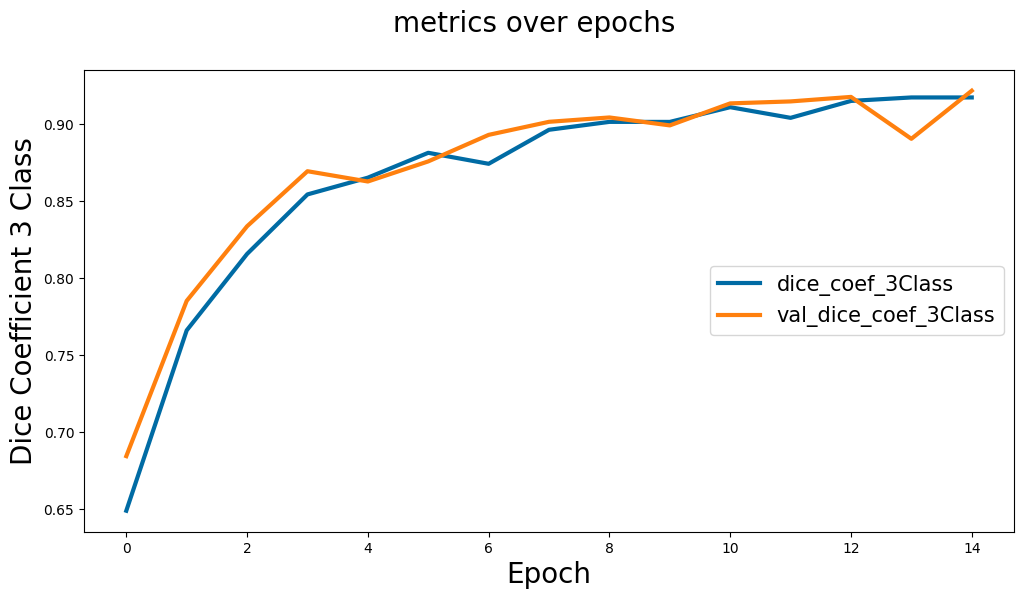

In [55]:
def plot_dice_history(history, metrics=["dice_coef_3Class","val_dice_coef_3Class"]):
    plt.style.use(['tableau-colorblind10'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("Dice Coefficient 3 Class", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_dice_history(history)

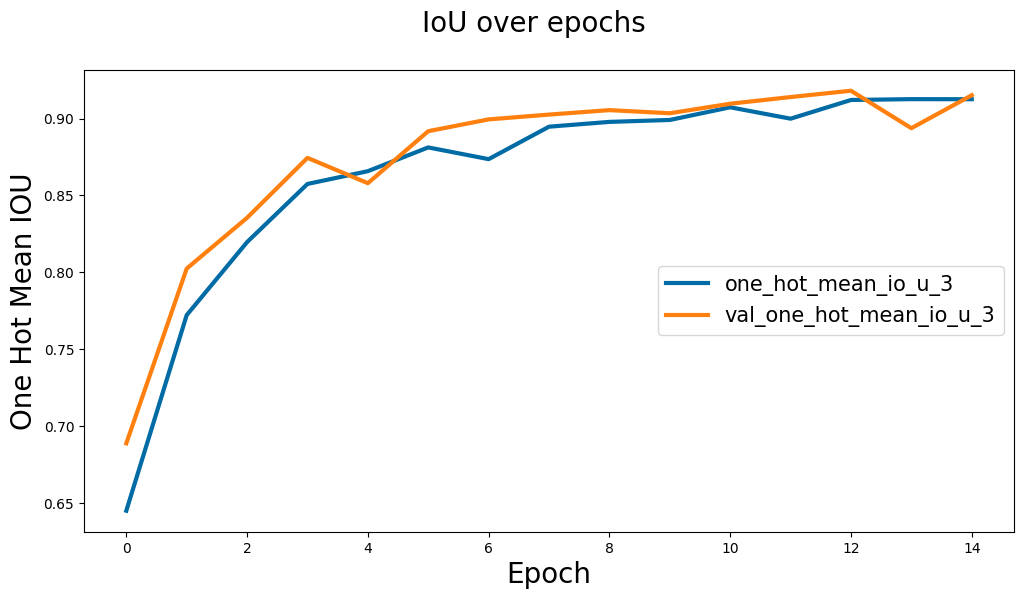

In [58]:
def plot_IoU_onehot_history(history, metrics=["one_hot_mean_io_u_3", "val_one_hot_mean_io_u_3"]):
    plt.style.use(['tableau-colorblind10'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("IoU over epochs", fontsize=20)
    plt.ylabel("One Hot Mean IOU", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_IoU_onehot_history(history)

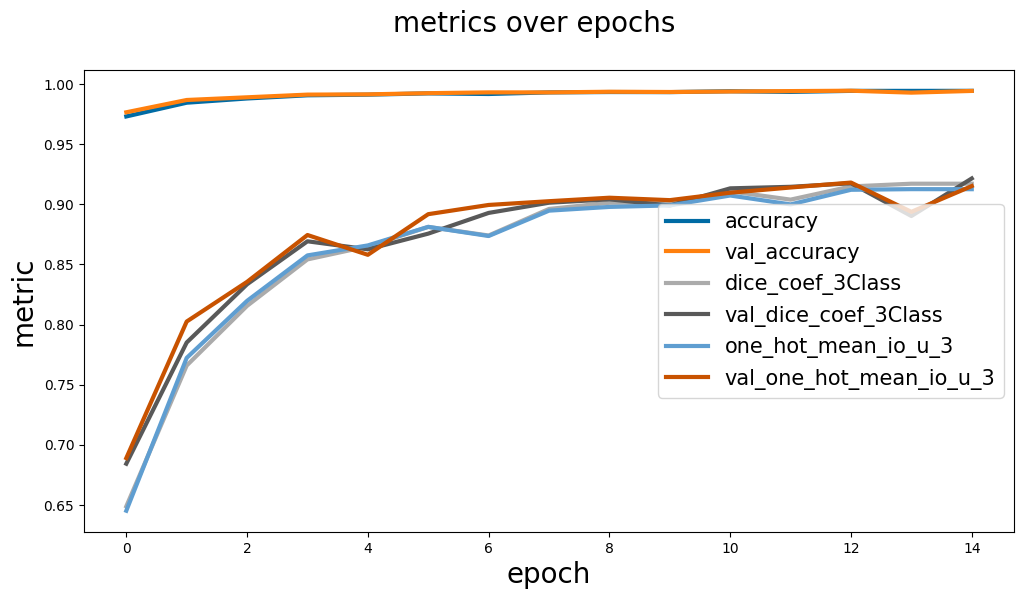

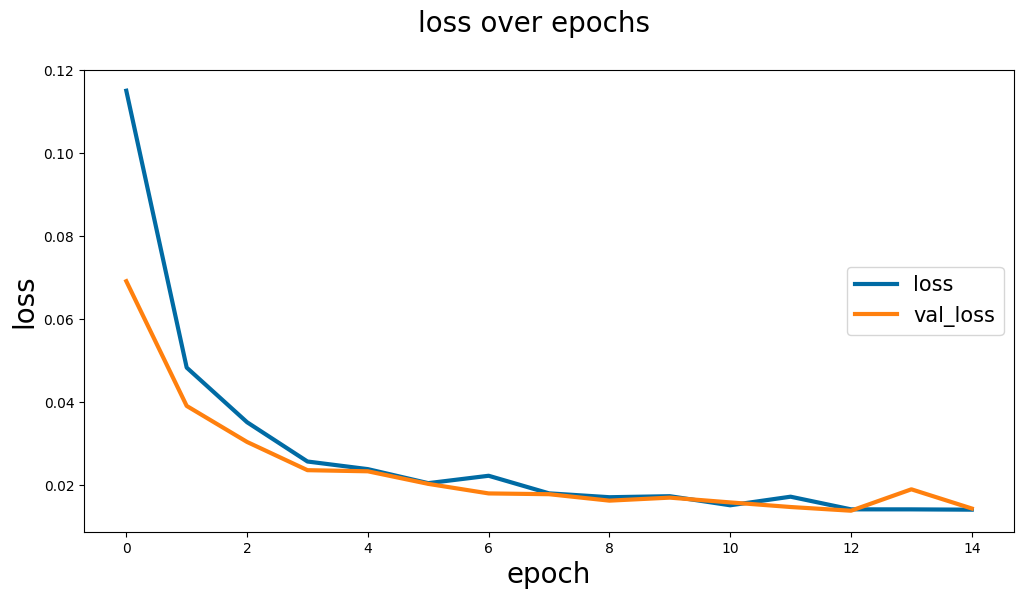

In [60]:
def plot_history(history, metrics=["accuracy", "val_accuracy","dice_coef_3Class","val_dice_coef_3Class", "one_hot_mean_io_u_3", "val_one_hot_mean_io_u_3"], losses=["loss", "val_loss"]):
    plt.style.use(['tableau-colorblind10'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("metric", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.show()

plot_history(history)

In [23]:
len(test_x)

712

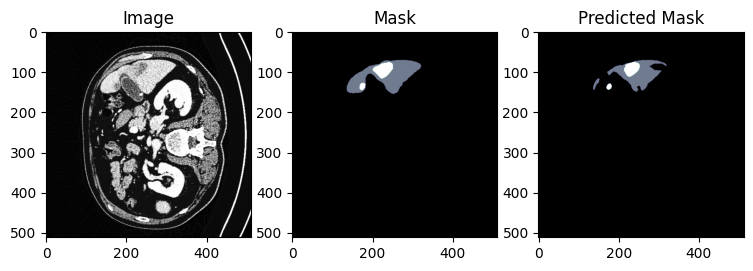

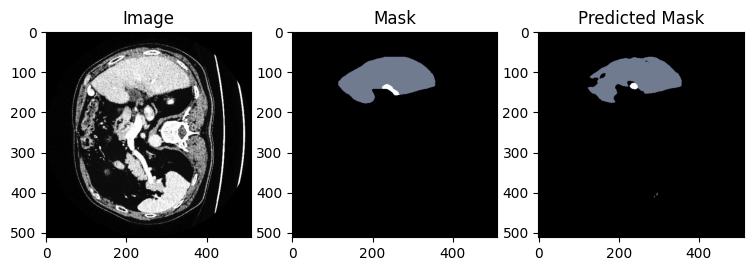

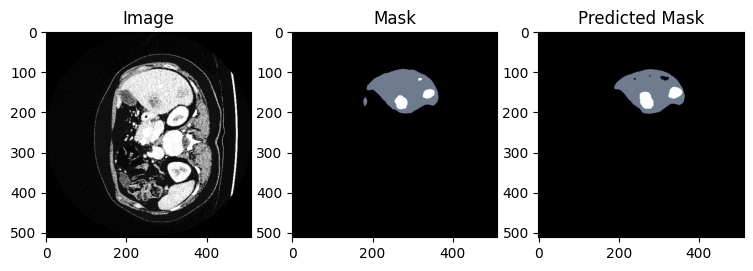

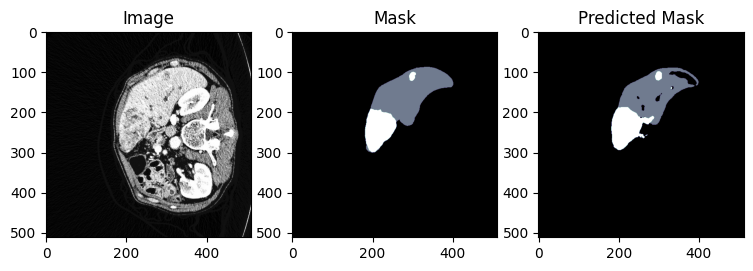

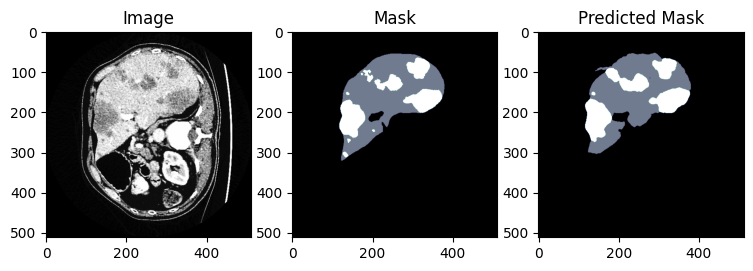

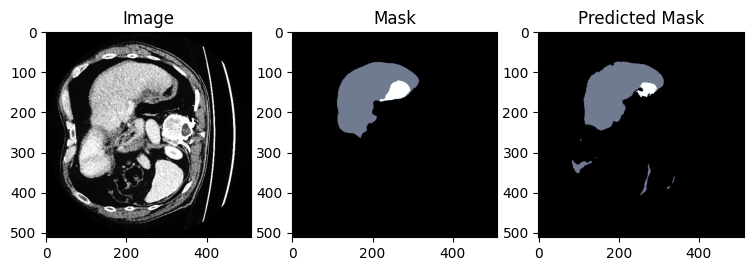

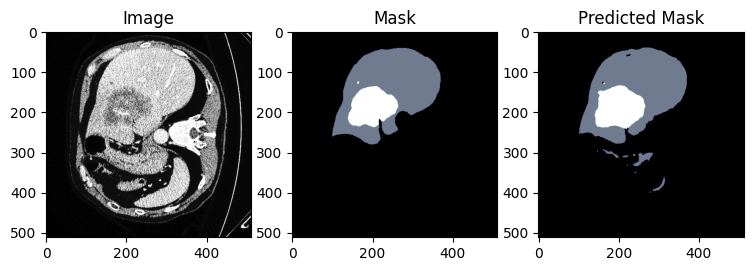

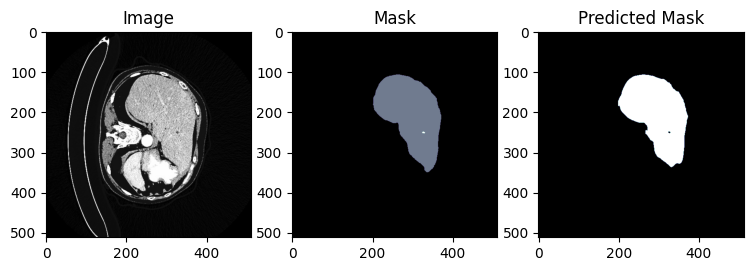

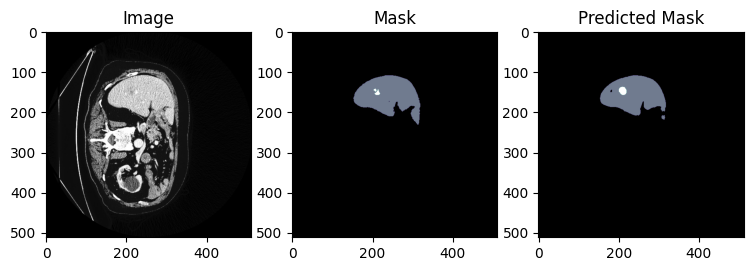

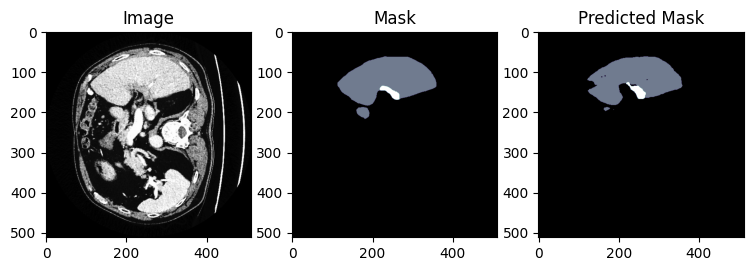

In [25]:
import random

l = random.sample(range(712), 10)


for i in l:
    img = test_x[i]
    image = read_image(img)

    image = np.expand_dims(image,axis=0)
    # print(image.shape)
    prediction = vgg16unet_model.predict(image).squeeze()
    prediction = np.argmax(prediction, axis=-1).astype(np.int32)
    
    
    # print(model.predict(image).squeeze().shape)

    visualize(image = read_image(test_x[i]), mask = read_mask(test_y[i]), predicted_mask = prediction)